In [6]:
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau

In [7]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [9]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                horizontal_flip=True,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                vertical_flip=True,
                fill_mode='nearest',
                validation_split=0.3)

validation_datagen = ImageDataGenerator(rescale = 1.0/255,
                                        validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150,150),
        batch_size=5,
        class_mode='categorical',
        subset='training')

validation_generator = validation_datagen.flow_from_directory(
        test_dir, 
        target_size=(150,150), 
        batch_size=5,
        class_mode='categorical',
        subset='validation')

Found 1061 images belonging to 4 classes.
Found 357 images belonging to 4 classes.


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    ## Change Dense number to Total Class exist
    tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 74, 74, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 16)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 36, 36, 16)       

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000003)
                                            
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[learning_rate_reduction])

Epoch 1/10


2022-06-12 18:02:47.547811: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-12 18:02:47.791523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


213/213 [==============================] - ETA: 0s - loss: 1.0950 - accuracy: 0.4392

2022-06-12 18:03:12.409317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


213/213 [==============================] - 31s 140ms/step - loss: 1.0950 - accuracy: 0.4392 - val_loss: 1.2563 - val_accuracy: 0.4706 - lr: 0.0010
Epoch 2/10
213/213 [==============================] - 29s 137ms/step - loss: 0.7143 - accuracy: 0.6664 - val_loss: 0.7857 - val_accuracy: 0.6415 - lr: 0.0010
Epoch 3/10
213/213 [==============================] - 30s 140ms/step - loss: 0.4499 - accuracy: 0.7917 - val_loss: 2.1088 - val_accuracy: 0.5602 - lr: 0.0010
Epoch 4/10
213/213 [==============================] - ETA: 0s - loss: 0.3929 - accuracy: 0.8303
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
213/213 [==============================] - 29s 138ms/step - loss: 0.3929 - accuracy: 0.8303 - val_loss: 3.4079 - val_accuracy: 0.5602 - lr: 0.0010
Epoch 5/10
213/213 [==============================] - 29s 134ms/step - loss: 0.1854 - accuracy: 0.9303 - val_loss: 4.5097 - val_accuracy: 0.5602 - lr: 5.0000e-04
Epoch 6/10
213/213 [==============================] - ET

In [12]:
def eval_plot(history):
    
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))
    acc_plot, = plt.plot(epochs, acc, 'r')
    val_acc_plot, = plt.plot(epochs, val_acc, 'b')
    plt.title('Training and Validation Accuracy')
    plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])

    # Loss plot
    plt.subplot(1, 2, 2)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    loss_plot, = plt.plot(epochs, loss, 'r')
    val_loss_plot, = plt.plot(epochs, val_loss, 'b')
    plt.title('Training and Validation Loss')
    plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def evaluate(model):
    
    validation_generator = train_datagen.flow_from_directory(
            test_dir, 
            target_size=(150,150), 
            batch_size=10, 
            class_mode='categorical',
            shuffle = False,
            subset='validation')

    batch_size = 10
    num_of_test_samples = len(validation_generator.filenames)

    Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
    y_pred = np.argmax(Y_pred, axis=1)

    print('\nConfusion Matrix\n')
    print(confusion_matrix(validation_generator.classes, y_pred))


    print('\n\nClassification Report\n')
    target_names = ['GINA', 'MATAHARI', 'SIRAT','ULI']
    print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

def predict_image(image_upload, model = model):
    im = image_upload
    im_array = np.asarray(im)
    im_array = im_array*(1/225)
    im_input = tf.reshape(im_array, shape = [1, 150, 150, 3])

    predict_proba = sorted(model.predict(im_input)[0])[2]
    predict_class = np.argmax(model.predict(im_input))

    if predict_class == 0:
        predict_label = 'Paper'
    elif predict_class == 1:
        predict_label = 'Rock'
    else:
        predict_label = 'Scissor'

    print('\n')
    plt.show()
    print("\nImage prediction result: ", predict_label)
    print("Probability: ", round(predict_proba*100,2), "%")
    print('\n')

Found 268 images belonging to 4 classes.


/var/folders/68/ws912nt53sj93j_v0j_wm41r0000gn/T/ipykernel_12719/3322511867.py:38: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
2022-06-12 18:07:41.371407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Confusion Matrix

[[22  0 21  0]
 [ 0  0 75  0]
 [ 0  0 75  0]
 [ 0  0  0 75]]


Classification Report

              precision    recall  f1-score   support

        GINA       1.00      0.51      0.68        43
    MATAHARI       0.00      0.00      0.00        75
       SIRAT       0.44      1.00      0.61        75
         ULI       1.00      1.00      1.00        75

    accuracy                           0.64       268
   macro avg       0.61      0.63      0.57       268
weighted avg       0.56      0.64      0.56       268



/Users/harysetiawan/Documents/College Project/PCD/FinalProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/harysetiawan/Documents/College Project/PCD/FinalProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/harysetiawan/Documents/College Project/PCD/FinalProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

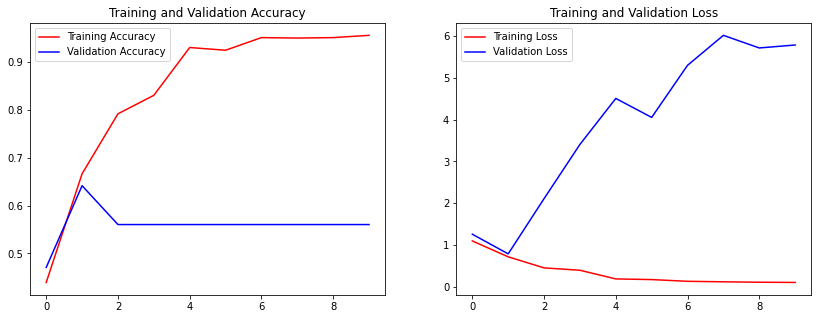

In [13]:
eval_plot(history)
evaluate(model)
